# Data preparation for DeepSDM

#### If it's your first time running the code, please install these packages

```
sudo apt install build-essential
sudo apt update
sudo apt install libpq-dev
sudo apt install software-properties-common
sudo add-apt-repository ppa:ubuntugis/ppa
sudo apt install gdal-bin
sudo apt install libgdal-dev
sudo apt install libgl1-mesa-glx
```

#### check the gdal version
```
gdalinfo --version
```

#### Install the python package gdal
```
pip install gdal==version
```

#### Install other packages for this ipynb
```
pip install rasterio
pip install umap-learn
pip install mlflow
```

#### The pytorch environment
- pytorch-lightning==2.0.6
- torch==1.13.1
- torchaudio==0.13.1
- torchvision==0.14.1
- torchmetrics==0.11.0

## Load packages

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import json
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from RasterHelper import RasterHelper
from CooccurrenceHelper import CooccurrenceHelper
from types import SimpleNamespace
from EmbeddingHelpers import CreateDataset, EmbeddingModel, TrainEmbedding
from matplotlib import pyplot as plt
import rasterio
import yaml

## Configurations

All data ranges for training, validating, and further predicting should be covered here.

They'll be converted to the format that DeepSDM accepts

A training data sample is constructed by the spatial unit × the temporal unit.

In [2]:
# load configurations
with open('DeepSDM_conf.yaml', 'r') as f:
    DeepSDM_conf = yaml.load(f, Loader = yaml.FullLoader)
DeepSDM_conf = SimpleNamespace(**DeepSDM_conf)

### Spatial config

The spatial unit of the training data is the `subsample`.

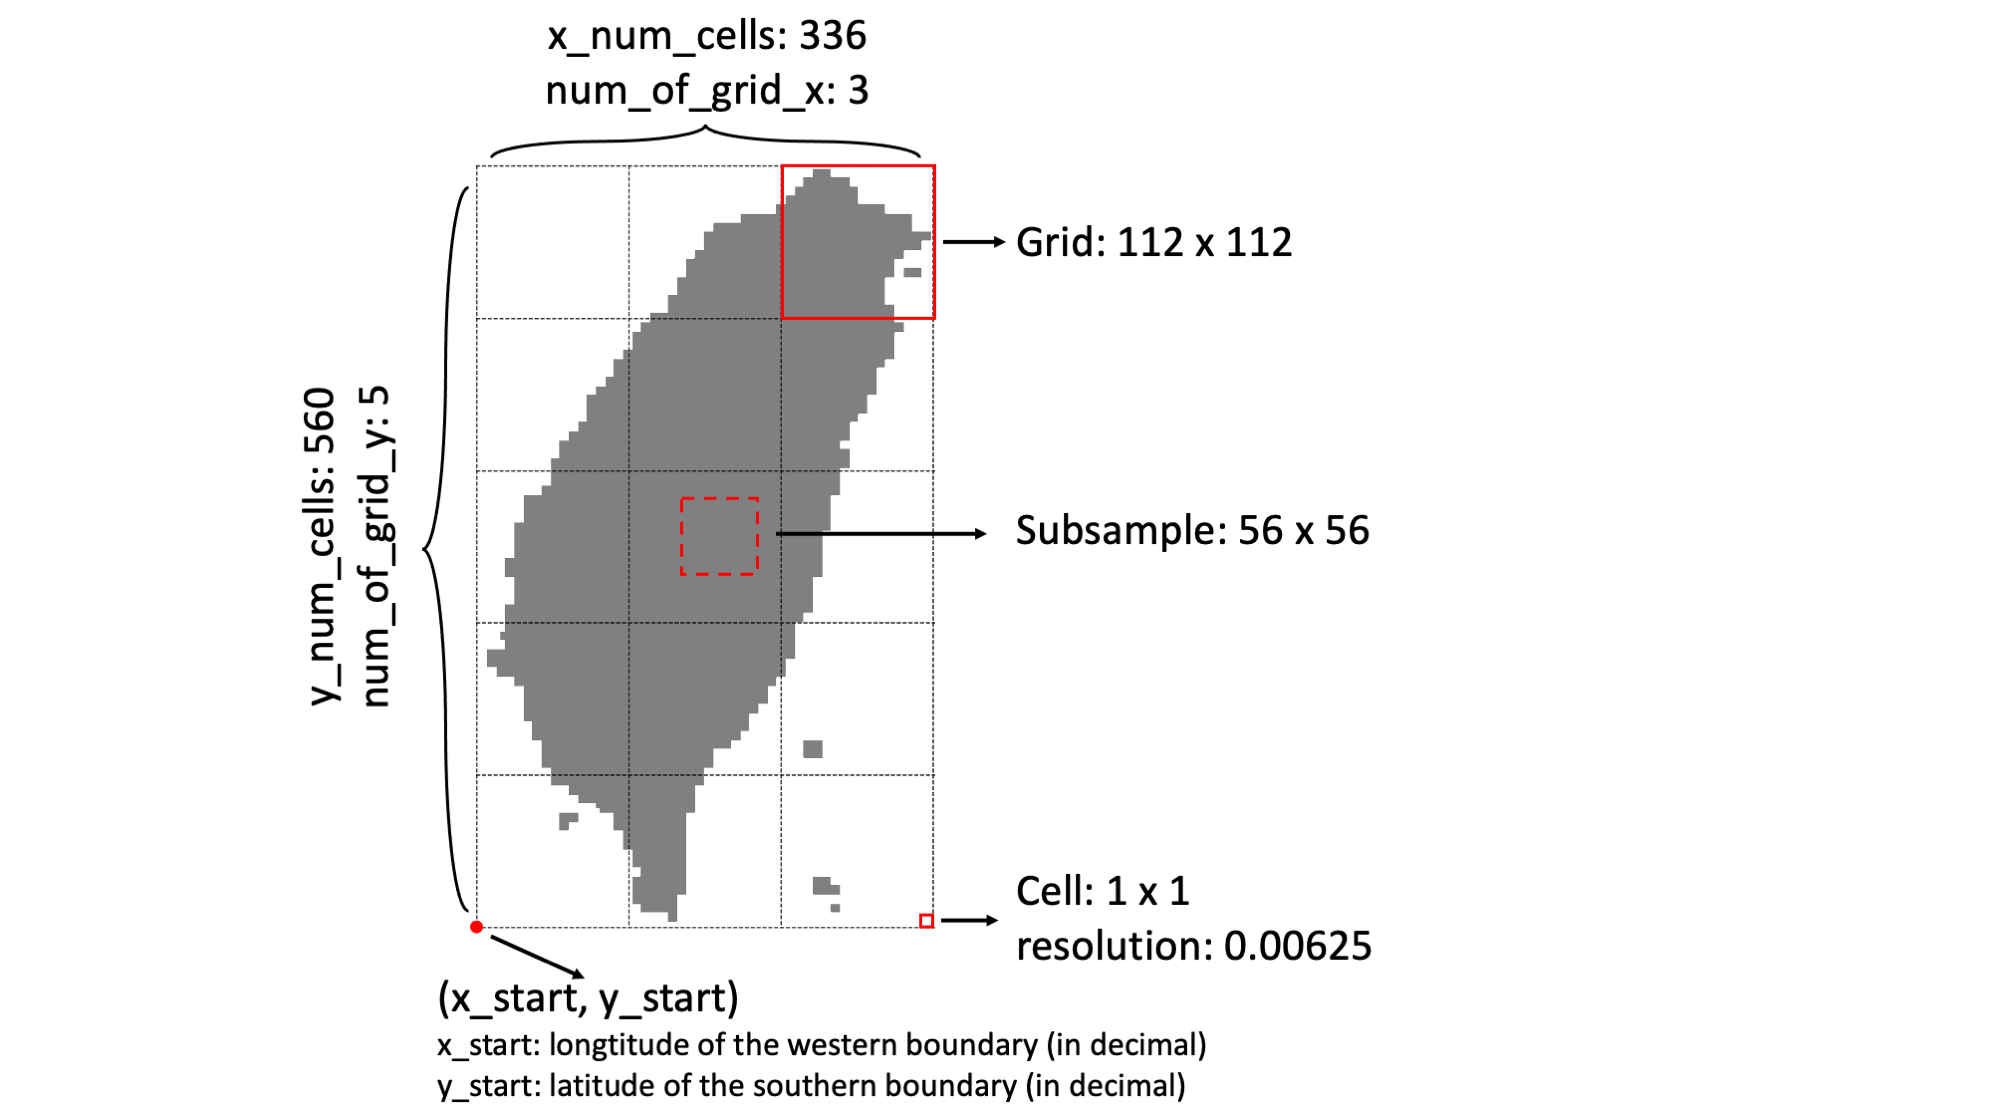

In [3]:
# Our settings
spatial_conf_tmp = SimpleNamespace(**DeepSDM_conf.spatial_conf_tmp)

# other examples
# spatial_conf_tmp = SimpleNamespace(**dict(
#     x_start = 119.5,
#     y_start = 21.5,
#     num_of_grid_x = 3,
#     num_of_grid_y = 4,
#     grid_size = 100, # must >= 56
#     out_res = 0.01, # optional, can be load from example tif
# ))

# spatial_conf_tmp = SimpleNamespace(**dict(
#     x_start = 119.5,
#     y_start = 21.5,
#     num_of_grid_x = 6,
#     num_of_grid_y = 8,
#     grid_size = 100, # must >= 56
#     out_res = 0.005, # optional, can be load from example tif
# ))

### Temporal config

The temporal unit of the training data is the overlapped, consecutive (month_step=1) 3-month (month_span=3) samples.

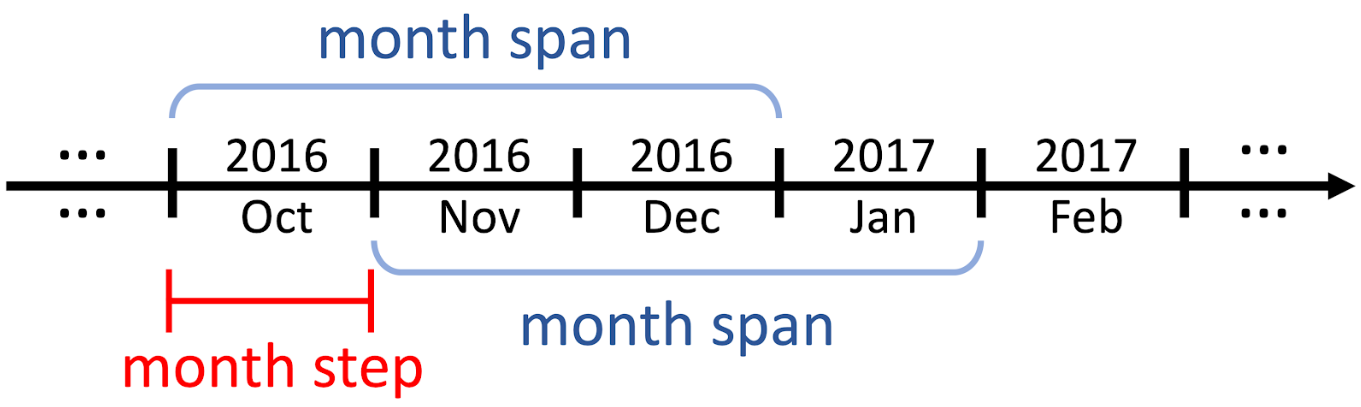

In [4]:
temporal_conf = SimpleNamespace(**DeepSDM_conf.temporal_conf)

## Preview the geo extent

In [5]:
# init raster helper
raster_helper = RasterHelper()
# generate the geo references with an example environmental tif layer and our spatial configurations
# choose/convert your reference tif of/to a general system such as WGS84 first, and so the following command will not go wrong
# e.g. the G1km_TWD97-121_DTM_ELE.tif (TWD97-TM2) is converted to G1km_WGS84_DTM_ELE.tif (WGS84) with QGIS
spatial_conf = raster_helper.create_extent_binary_from_env_layer(DeepSDM_conf.file_make_extent, spatial_conf_tmp)
# spatial_conf = raster_helper.create_extent_binary_from_env_layer('/home/trashmai/shared/chile/CNN/env_raw/DEM/NASADEM_NC.001_NASADEM_HGT_doy2000042_aid0001.tif', spatial_conf_tmp)
print(spatial_conf)

namespace(grid_size=112, num_of_grid_x=3, num_of_grid_y=5, out_res=0.00625, x_start=119.95, y_start=21.85, x_num_cells=336, y_num_cells=560, x_end=122.05, y_end=25.35)


-9999.0 7294.5786


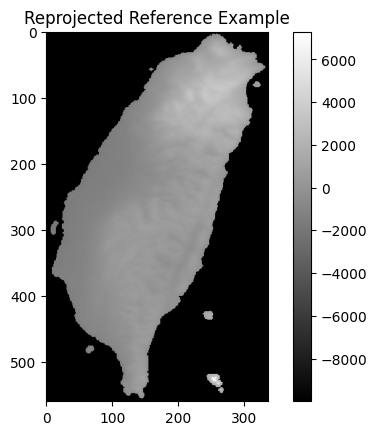

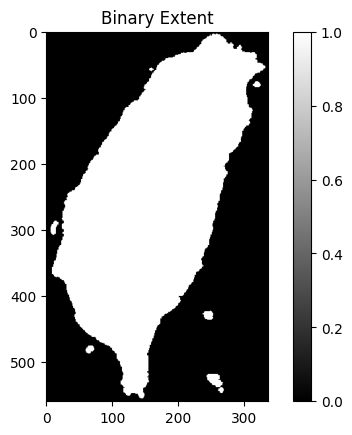

In [6]:
# # view the example layer

# with rasterio.open('/home/trashmai/gsmai/DeepSDM/medium/evi/evi_2000_02.tif') as src:
#     # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
#     array = src.read(1)
#     print(array.min())
#     # Plot the array
#     plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
#     plt.colorbar()
#     plt.title('EVI')
#     plt.show()

# with rasterio.open('/home/trashmai/gsmai/DeepSDM/workspace/raster_data/species_occurrence/Zosterops_simplex/Zosterops_simplex_2011-12-01.tif') as src:
#     # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
#     array = src.read(1)
#     print(array.min())
#     # Plot the array
#     plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
#     plt.colorbar()
#     plt.title('Species')
#     plt.show()

# with rasterio.open('/home/trashmai/gsmai/DeepSDM/workspace/raster_data/k/k_2003-05-01.tif') as src:
#     # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
#     array = src.read(1)
#     print(array.min())
#     # Plot the array
#     plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
#     plt.colorbar()
#     plt.title('K')
#     plt.show()

# view the example layer
with rasterio.open('./workspace/extent_env_example.tif') as src:
    # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
    array = src.read(1)
    print(array.min(), array.max())
    # Plot the array
    plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
    plt.colorbar()
    plt.title('Reprojected Reference Example')
    plt.show()

# view the binary extent (1, white, cells with env data; 0, black, cells without env data)
with rasterio.open('./workspace/extent_binary.tif') as src:
    # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
    array = src.read(1)
    # Plot the array
    plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
    plt.colorbar()
    plt.title('Binary Extent')
    plt.show()
    

## Random split train, val grids.

In [7]:
raster_helper.random_split_train_val(train_ratio=0.7)

Partition saved at ./workspace/partition.txt.


## Preview the splits
You can repeat the random split until you get a satisfying split result, or you can modify the output partition.txt file to adjust the arrangement of the train and val grids as you wish.

You can also copy the ./raw/partition.txt we prepared to ./workspace in the demo.
- 0: val
- 1: train

In [8]:
# Uncomment and run following lines to use our partition
import shutil
shutil.copy2('./raw/partition_default.txt', './workspace/partition.txt')

'./workspace/partition.txt'

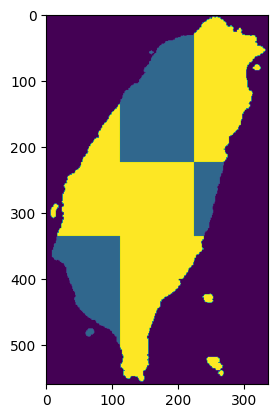

In [9]:
raster_helper.view_train_val_splits()

## Env raster configurations

- The raw env data listed in "env_list" must be put in the ./raw/env/{env} directory.
- The env_no_need_avg indicates those env data that don't change much, e.g. elevation.
- The env_filename_templates describe the file name patterns of each evn. The [YYYY] is the year and the [MM] is the month.
- If your env filename ends with file extension other than 'tif', modify the ext.

## Divide and align environment rasters according to our spatial and temporal configurations.

In [10]:
# other than CCI land cover data
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.raw_to_medium(DeepSDM_conf.env_raw_conf)

# CCI land cover data
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.raw_to_medium_CCI(DeepSDM_conf.CCI_conf)

# log the medium environment list
raster_helper.log_env_medium_list()

{'env_out_template': 'EVI_[YEAR]_[MONTH].tif', 'filename_template': 'MOD13A1.006__500m_16_days_EVI_doy[YEAR][DOY]_aid0001.tif', 'raw_env_dir': '/work/klok0126/other_env/EVI'}


/home/klok0126/DeepSDM/RasterHelper.py:217: RuntimeWarning: Mean of empty slice
  mem_raster_arr_avg = np.nanmean(np.stack(mem_raster_arrs), axis=0)


{'env_out_template': 'clt_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_clt_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/clt_'}
{'env_out_template': 'cmi_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_cmi_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/cmi_'}
{'env_out_template': 'elev.tif', 'filename_template': 'wc2.1_30s_elev.tif', 'raw_env_dir': '/work/klok0126/other_env/elev'}
{'env_out_template': 'hurs_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_hurs_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/hurs_'}
{'env_out_template': 'pet_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_pet_penman_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/pet_'}
{'env_out_template': 'pr_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_pr_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/pr_'}


Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use officia

{'env_out_template': 'rsds_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_rsds_[YEAR]_[MONTH]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/rsds_'}


Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use officia

{'env_out_template': 'sfcWind_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_sfcWind_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/sfcWind_'}
{'env_out_template': 'tas_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_tas_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/tas_'}
{'env_out_template': 'tasmax_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_tasmax_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/tasmax_'}
{'env_out_template': 'tasmin_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_tasmin_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/tasmin_'}
{'env_out_template': 'vpd_[YEAR]_[MONTH].tif', 'filename_template': 'CHELSA_vpd_[MONTH]_[YEAR]_V.2.1.tif', 'raw_env_dir': '/work/klok0126/Chelsa/vpd_'}
{'PCA': 0.9, 'env_out_template': 'landcover_[CLASS]/landcover_[CLASS]_[YEAR].tif', 'filename_template': 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-[YEAR]-v2.0.7cds.nc', 'layer_name': 'lccs_class', 'raw_env_dir': '/work/kl

## Print the landcover PCA result

In [11]:
landcover_info = {
    0: 'No Data',
    10: 'Cropland, rainfed',
    11: 'Cropland, rainfed, herbaceous cover',
    12: 'Cropland, rainfed, tree or shrub cover',
    20: 'Cropland, irrigated or post-flooding',
    30: 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)',
    40: 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)',
    50: 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
    60: 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
    61: 'Tree cover, broadleaved, deciduous, closed (>40%)',
    62: 'Tree cover, broadleaved, deciduous, open (15-40%)',
    70: 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
    71: 'Tree cover, needleleaved, evergreen, closed (>40%)',
    72: 'Tree cover, needleleaved, evergreen, open (15-40%)',
    80: 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
    81: 'Tree cover, needleleaved, deciduous, closed (>40%)',
    82: 'Tree cover, needleleaved, deciduous, open (15-40%)',
    90: 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
    100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
    110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
    120: 'Shrubland',
    121: 'Evergreen shrubland',
    122: 'Deciduous shrubland',
    130: 'Grassland',
    140: 'Lichens and mosses',
    150: 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
    151: 'Sparse tree (<15%)',
    152: 'Sparse shrub (<15%)',
    153: 'Sparse herbaceous cover (<15%)',
    160: 'Tree cover, flooded, fresh or brackish water',
    170: 'Tree cover, flooded, saline water',
    180: 'Shrub or herbaceous cover, flooded, fresh/saline/brackish water',
    190: 'Urban areas',
    200: 'Bare areas',
    201: 'Consolidated bare areas',
    202: 'Unconsolidated bare areas',
    210: 'Water bodies',
    220: 'Permanent snow and ice'
}
landcover_class = [10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190, 200, 201, 202, 210, 220]

In [12]:
for i_pca in range(5):
    print(f'\nPCA{i_pca+1} (explains {raster_helper.CCI_PCA_variance_ratio[i_pca]*100:02f}% of variance):\n')
    idx = (abs(raster_helper.CCI_PCA_components[i_pca]).argsort())[-7:]
    for i in range(7):
        print(f'{landcover_class[idx[::-1][i]]} {landcover_info[landcover_class[idx[::-1][i]]]} {raster_helper.CCI_PCA_components[i_pca][idx][::-1][i]:02f}')


PCA1 (explains 48.494592% of variance):

50 Tree cover, broadleaved, evergreen, closed to open (>15%) -0.910246
10 Cropland, rainfed 0.280535
20 Cropland, irrigated or post-flooding 0.233243
11 Cropland, rainfed, herbaceous cover 0.144718
30 Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%) 0.089471
190 Urban areas 0.089204
40 Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) 0.031325

PCA2 (explains 16.088378% of variance):

10 Cropland, rainfed 0.761094
20 Cropland, irrigated or post-flooding -0.639366
11 Cropland, rainfed, herbaceous cover -0.083285
50 Tree cover, broadleaved, evergreen, closed to open (>15%) 0.050296
30 Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%) -0.034486
190 Urban areas -0.034328
40 Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) -0.008960

PCA3 (explains 12.229809% of variance):

11 Cropland, rainfed, herbaceous cover 0.693

In [22]:
loadings = raster_helper.CCI_PCA_components.T * np.sqrt(raster_helper.CCI_PCA_variance_ratio)

In [26]:
pd.DataFrame(loadings, index = landcover_class, columns = [f'landcoverPC{i+1}' for i in range(len(landcover_class))]).to_csv('./workspace/CCI_PCA.csv')

## Averaging rasters according to the time span
3 consecutive months in this example

In [11]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.avg_and_mask_env_timespan()

EVI


/home/klok0126/DeepSDM_2000_2019/RasterHelper.py:551: RuntimeWarning: Mean of empty slice
  env_arr_span_avg = np.nanmean(np.stack(env_arrs), axis=0)


clt
cmi
elev
hurs
pet
pr
rsds
sfcWind
tas
tasmax
tasmin
vpd
landcover_PC00
landcover_PC01
landcover_PC02
landcover_PC03
landcover_PC04


## We read GBIF occurrence file and make simple data clearance.

We select some essential columns for DeepSDM, and remove rows with empty column(s).
- species
- decimalLatitude, decimalLongitude
- day
- month
- year

In [12]:
# target_species = DeepSDM_conf.species_list_all_resident

In [13]:
cooccur_helper = CooccurrenceHelper(spatial_conf, temporal_conf)

In [14]:
# cooccur_helper.filter_occurrence(gbif_occurrence_csv='/home/klok0126/DeepSDM/raw/species_occurrence_raw_50k.csv')
cooccur_helper.filter_occurrence(gbif_occurrence_csv = DeepSDM_conf.gbif_occurrence_csv)

/home/klok0126/DeepSDM_2000_2019/CooccurrenceHelper.py:68: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  self.species_raw = pd.read_csv(self.gbif_occurrence_csv,


File: ./workspace/species_data/occurrence_data/species_occurrence_filter.csv saved.


## Create species rasters that aligned to the geo extent.

In [15]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.create_species_raster()

## Create effort-weight rasters for calculating effort-weighted loss.

In [16]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.create_k_info()

## Get cooccurrence embeddings with cooccurrence data

In [17]:
embedding_conf = SimpleNamespace(**DeepSDM_conf.embedding_conf)
cooccurrence_conf = SimpleNamespace(**DeepSDM_conf.cooccurrence_conf)
cooccur_helper.aggregate_cooccurrence_units(sp_filter_from = cooccurrence_conf.sp_filter_from, 
                                            cooccurrence_xy_mul = cooccurrence_conf.cooccurrence_xy_mul, 
                                            cooccurrence_day_mul = cooccurrence_conf.cooccurrence_day_mul)

Aggregating data costs 10.745450496673584 seconds.


In [ ]:
cooccur_helper.count_cooccurrence_mod()
TM = TrainEmbedding(embedding_conf, CreateDataset, EmbeddingModel)
TM.setup()
TM.train()
TM.log_embedding_result()

## Visualize species cooccurrence embeddings

### Exploring embeddings (optional)

You can access the embeddings with TM.embedding, and draw colors along the elevation or categories such as mountain birds and water birds.

In [ ]:
# TM.visualize_embedding()